## Importing Libraries

In [112]:
import gym
import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import gym.spaces
from gym.envs.registration import register
from gym.envs import toy_text
import torch.nn.functional as F
from torch.distributions import Categorical

## Defining the Quantum Circuits and the DQN

In [113]:
def encode(n_qubits, inputs):
    for wire in range(n_qubits):
        qml.RX(inputs[wire], wires=wire)


def layer(n_qubits, y_weight, z_weight):
    for wire, y_weight in enumerate(y_weight):
        qml.RY(y_weight, wires=wire)
    for wire, z_weight in enumerate(z_weight):
        qml.RZ(z_weight, wires=wire)
    for wire in range(n_qubits):
        qml.CZ(wires=[wire, (wire + 1) % n_qubits])


def measure(n_qubits):
    return [
        qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)),
        qml.expval(qml.PauliZ(2) @ qml.PauliZ(3))
    ]


def get_model(n_qubits, n_layers, data_reupload):
    dev = qml.device("default.qubit", wires=n_qubits)
    shapes = {
        "y_weights": (n_layers, n_qubits),
        "z_weights": (n_layers, n_qubits)
    }

    @qml.qnode(dev, interface='torch')
    def circuit(inputs, y_weights, z_weights):
        for layer_idx in range(n_layers):
            if (layer_idx == 0) or data_reupload:
                encode(n_qubits, inputs)
            layer(n_qubits, y_weights[layer_idx], z_weights[layer_idx])
        return measure(n_qubits)

    model = qml.qnn.TorchLayer(circuit, shapes)

    return model


class QuantumNet(nn.Module):

    def __init__(self, n_layers, w_input, w_output, data_reupload = True):
        super(QuantumNet, self).__init__()
        self.n_qubits = 4
        self.n_actions = 2
        self.data_reupload = data_reupload
        self.q_layers = get_model(n_qubits=self.n_qubits,
                                  n_layers=n_layers,
                                  data_reupload=data_reupload)
        if w_input:
            self.w_input = Parameter(torch.Tensor(self.n_qubits))
            nn.init.normal_(self.w_input, mean=0.)
        else:
            self.register_parameter('w_input', None)
        if w_output:
            self.w_output = Parameter(torch.Tensor(self.n_actions))
            nn.init.normal_(self.w_output, mean=90.)
        else:
            self.register_parameter('w_output', None)

    def forward(self, inputs):
        if self.w_input is not None:
            inputs = inputs * self.w_input
        inputs = torch.atan(inputs)
        outputs = self.q_layers(inputs)
        outputs = (1 + outputs) / 2
        if self.w_output is not None:
            outputs = outputs * self.w_output
        else:
            outputs = 90 * outputs
        return outputs

In [114]:
env = gym.make("CartPole-v1")

In [115]:
device = torch.device("cpu")

In [116]:
dicts = torch.load("cartnet.pt")
print(dicts)

OrderedDict([('w_input', tensor([-0.0675, -0.0233,  2.1304,  0.3109])), ('w_output', tensor([102.4290, 101.6808])), ('q_layers.y_weights', tensor([[1.8979, 0.9439, 0.1321, 3.4829],
        [5.1669, 0.7550, 2.7817, 1.6648],
        [1.2001, 0.8215, 3.4144, 2.0073],
        [1.7737, 3.5922, 3.1793, 4.3895],
        [0.7004, 3.7127, 6.2669, 2.4820]])), ('q_layers.z_weights', tensor([[ 3.3732,  1.5915,  2.3775,  2.1786],
        [ 4.6642,  1.2701,  6.7394, -0.0310],
        [ 0.3916,  6.8138, -1.0576,  2.5492],
        [ 3.6524,  0.0221,  2.1502,  3.0487],
        [ 0.5994,  3.0209,  3.1120,  5.0410]]))])


In [117]:
"""from collections import OrderedDict
 
new_dict = OrderedDict([
    ('q_layers.y_weights', dicts['q_layers.y_weights']),
    ('q_layers.z_weights', dicts['q_layers.z_weights'])
])
print(new_dict)

w_input = dicts['w_input']
w_output = dicts['w_output']"""

"from collections import OrderedDict\n \nnew_dict = OrderedDict([\n    ('q_layers.y_weights', dicts['q_layers.y_weights']),\n    ('q_layers.z_weights', dicts['q_layers.z_weights'])\n])\nprint(new_dict)\n\nw_input = dicts['w_input']\nw_output = dicts['w_output']"

In [118]:
#print(w_input)

In [119]:
model = QuantumNet(5, True, True)
model.load_state_dict(dicts)

<All keys matched successfully>

In [120]:
model = model.to(device)

## Function for testing the Agent

In [121]:
def evaluate_agent(env, model, episodes):
    episode_steps = []
    episode_reward = []

    for _ in range(episodes):
        state,_ = env.reset()
        done = False
        episode_steps.append(0)
        episode_reward.append(0)
        while not done:
            state = torch.FloatTensor(state).to(device)
            q_values = model.eval()(state)
            _, action = torch.max(q_values, dim=0)
            action =  int(action.item())
            next_state, reward, terminated, truncated ,_= env.step(action)
            done = terminated or truncated
            state = next_state
            episode_steps[-1] += 1
            episode_reward[-1] += reward

    env.close()
    val = [episode_steps, episode_reward]
    episode_steps = np.mean(episode_steps)
    episode_reward = np.mean(episode_reward)
    return ({'steps': episode_steps, 'reward': episode_reward},val)


## Testing the agent

In [122]:
dicts, array = evaluate_agent(env, model, 5)

In [123]:
print(array)

[[123, 210, 183, 128, 194], [123.0, 210.0, 183.0, 128.0, 194.0]]


In [124]:
steps, rewards = array

In [125]:
import matplotlib.pyplot as plt

episodes = [1, 2, 3, 4, 5]

Text(0, 0.5, 'Reward')

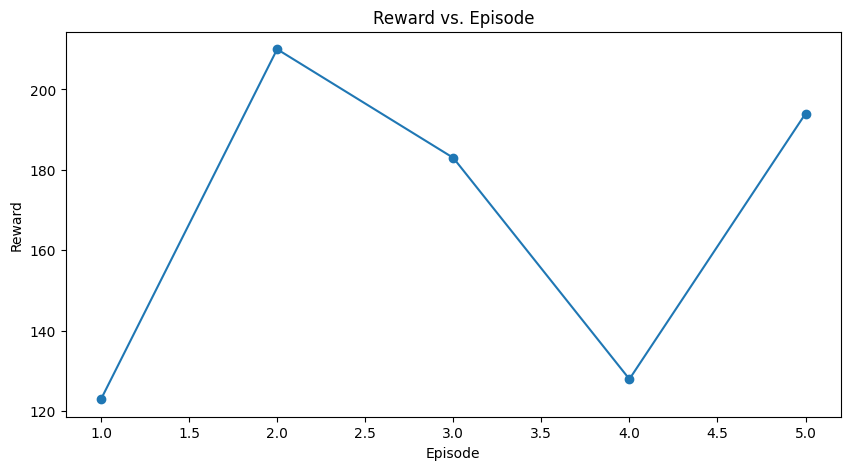

In [126]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)  # 1 row, 2 columns, plot 1
plt.plot(episodes, rewards, marker='o')
plt.title('Reward vs. Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')

In [127]:
# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

<Figure size 640x480 with 0 Axes>

In [128]:
print(dicts)

{'steps': 167.6, 'reward': 167.6}
